Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from statsmodels.formula.api import ols

Read election results by county csv to dataframe and filter for Donald Trump votes in 2016

In [2]:
results_df = pd.read_csv('election_results.csv')
results_df = results_df[(results_df['year'] == 2016)&(results_df['candidate'] == 'Donald Trump')]
results_df.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
40518,2016,Alabama,AL,Autauga,1001.0,President,Donald Trump,republican,18172.0,24973,20191203
40521,2016,Alabama,AL,Baldwin,1003.0,President,Donald Trump,republican,72883.0,95215,20191203
40524,2016,Alabama,AL,Barbour,1005.0,President,Donald Trump,republican,5454.0,10469,20191203
40527,2016,Alabama,AL,Bibb,1007.0,President,Donald Trump,republican,6738.0,8819,20191203
40530,2016,Alabama,AL,Blount,1009.0,President,Donald Trump,republican,22859.0,25588,20191203


Find and drop voteless counties

In [3]:
results_df.drop(results_df[(results_df['totalvotes'] == 0)].index, inplace = True)
results_df.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
40518,2016,Alabama,AL,Autauga,1001.0,President,Donald Trump,republican,18172.0,24973,20191203
40521,2016,Alabama,AL,Baldwin,1003.0,President,Donald Trump,republican,72883.0,95215,20191203
40524,2016,Alabama,AL,Barbour,1005.0,President,Donald Trump,republican,5454.0,10469,20191203
40527,2016,Alabama,AL,Bibb,1007.0,President,Donald Trump,republican,6738.0,8819,20191203
40530,2016,Alabama,AL,Blount,1009.0,President,Donald Trump,republican,22859.0,25588,20191203


Calculate Donald Trump proportion of votes by county, create county, state column and drop uneeded coumns

In [4]:
results_df['voteproportion'] = results_df.apply(lambda x: x['candidatevotes']/x['totalvotes'], axis=1)
results_df['countystate'] = results_df['county'] + ' County, ' + results_df['state']
results_df['Areaname'] = results_df['county'] + ', ' + results_df['state_po']
results_df.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version,voteproportion,countystate,Areaname
40518,2016,Alabama,AL,Autauga,1001.0,President,Donald Trump,republican,18172.0,24973,20191203,0.727666,"Autauga County, Alabama","Autauga, AL"
40521,2016,Alabama,AL,Baldwin,1003.0,President,Donald Trump,republican,72883.0,95215,20191203,0.765457,"Baldwin County, Alabama","Baldwin, AL"
40524,2016,Alabama,AL,Barbour,1005.0,President,Donald Trump,republican,5454.0,10469,20191203,0.520967,"Barbour County, Alabama","Barbour, AL"
40527,2016,Alabama,AL,Bibb,1007.0,President,Donald Trump,republican,6738.0,8819,20191203,0.764032,"Bibb County, Alabama","Bibb, AL"
40530,2016,Alabama,AL,Blount,1009.0,President,Donald Trump,republican,22859.0,25588,20191203,0.893348,"Blount County, Alabama","Blount, AL"


Update duplicate results df county equivalent names in Virginia to specify independent city

In [5]:
results_df.loc[49206, 'countystate'] = 'Fairfax city, Virginia'
results_df.loc[49206, 'Areaname'] = 'Fairfax city, Va'
results_df.loc[49269, 'countystate'] = 'Roanoke city, Virginia'
results_df.loc[49269, 'Areaname'] = 'Roanoke city, Va'
results_df.loc[49266, 'countystate'] = 'Richmond city, Virginia'
results_df.loc[49266, 'Areaname'] = 'Richmond city, Va'
results_df.loc[49212, 'countystate'] = 'Franklin city, Virginia'
results_df.loc[49212, 'Areaname'] = 'Franklin city, Va'
results_df[results_df['state']=='Virginia'].groupby('countystate')['state'].count().sort_values(ascending=False).head()

countystate
York County, Virginia         1
Giles County, Virginia        1
Dinwiddie County, Virginia    1
Emporia County, Virginia      1
Essex County, Virginia        1
Name: state, dtype: int64

Update duplicate area df county equivalent names in Virginia to specify independent city

In [6]:
area_df = pd.read_csv('area.csv')
area_df.loc[2965, 'Areaname'] = 'Bedford city, Va'
area_df.loc[2975, 'Areaname'] = 'Fairfax city, Va'
area_df.loc[2995, 'Areaname'] = 'Roanoke city, Va'
area_df.loc[2996, 'Areaname'] = 'Richmond city, Va'
area_df.loc[2977, 'Areaname'] = 'Franklin city, Va'
area_df.groupby('Areaname')['Areaname'].count().sort_values(ascending=False).head()

Areaname
Ziebach, SD      1
Gooding, ID      1
Goochland, VA    1
Gonzales, TX     1
Goliad, TX       1
Name: Areaname, dtype: int64

Merge results df with area df and isolate needed columns

In [7]:
results_df = pd.merge(results_df, area_df, how='inner', on=['Areaname', 'Areaname'])
results_df['landarea'] = results_df['LND110210D']
results_df = results_df[['countystate', 'county', 'state', 'voteproportion','landarea']]
print(results_df.shape)
results_df.head()

(3102, 5)


,countystate,county,state,voteproportion,landarea
0,"Autauga County, Alabama",Autauga,Alabama,0.727666,594.44
1,"Baldwin County, Alabama",Baldwin,Alabama,0.765457,1589.78
2,"Barbour County, Alabama",Barbour,Alabama,0.520967,884.88
3,"Bibb County, Alabama",Bibb,Alabama,0.764032,622.58
4,"Blount County, Alabama",Blount,Alabama,0.893348,644.78


Write function to read census csv files and create df with needed columns

In [8]:
def census_format(file_name, input_column_names, output_column_names):
    df = pd.read_csv(file_name, header=[0,1])
    df['countystate'] = df['NAME']
    input_column_names.append('countystate')
    output_column_names.append('countystate')
    df = df[input_column_names]
    df.columns = output_column_names
    return df

Use census_format function to read census csv files and create dfs

In [9]:
age_df = census_format('age.csv', ['S0101_C01_030E','S0101_C01_001E'], ['medianage','population'])
income_df = census_format('income.csv', ['S1902_C02_015E'], ['income'])
language_df = census_format('language.csv', ['S1601_C01_003E'],['nonenglish'])
unemployment_df = census_format('unemployment.csv', ['S2301_C04_001E'],['unemployment'])
education_df = census_format('education.csv', ['S1501_C02_012E'],['bachelorsdegree'])
race_df = census_format('race.csv', ['DP05_0032PE','DP05_0033PE','DP05_0034PE','DP05_0039PE','DP05_0047PE','DP05_0066PE'],['white','black','nativea','asian','pacifici','hispanic'])
veteran_df = census_format('veteran.csv', ['S2101_C03_001E'],['veteran'])
disability_df = census_format('disability.csv', ['S1810_C03_001E'],['disability%'])
industry_df = census_format('industry.csv', ['S2403_C01_006E','S2403_C01_003E','S2403_C01_004E'],['manufacturing', 'agriculture','mining'])


Merge dfs for each census csv file with results df to create df with all data

In [10]:
test = pd.merge(age_df, results_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, income_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, language_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, unemployment_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, education_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, race_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, veteran_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, disability_df, how='inner', on=['countystate', 'countystate'])
test = pd.merge(test, industry_df, how='inner', on=['countystate', 'countystate'])

Clean test df, including 1) replace missing values with column mean 2) convert numeric values
to float type 3) Calculate interaction variables 4)Transform non-linear relationships

In [11]:
test.replace({'N':None},inplace=True)

test['unemployment'] = test['unemployment'].astype(float)
test['bachelorsdegree'] = test['bachelorsdegree'].astype(float)
test['white'] = test['white'].astype(float)
test['black'] = test['black'].astype(float)
test['nativea'] = test['nativea'].astype(float)
test['asian'] = test['asian'].astype(float)
test['pacifici'] = test['pacifici'].astype(float)
test['hispanic'] = test['hispanic'].astype(float)
test['bachelorsdegree'] = test['bachelorsdegree'].astype(float)
test['nonenglish'] = test['nonenglish'].astype(float)
test['mining'] = test['mining'].astype(float)
test['agriculture'] = test['agriculture'].astype(float)
test['manufacturing'] = test['manufacturing'].astype(float)

test.replace({None:np.nan},inplace=True)
test['nonengproportion'] = test['nonenglish']/test['population']
test['popdensity'] = test['population']/test['landarea']
test['veteran%'] = test['veteran']/test['population']
test['mining/capita'] = test['mining']/test['population']
test['agriculture/capita'] = test['agriculture']/test['population']
test['manufacturing/capita'] = test['manufacturing']/test['population']

test['popdensityroot'] = test['popdensity'].apply(lambda x:x**(1/10))
test['incomeroot'] = test['income'].apply(lambda x:x**(1/10))
test['medianageroot'] = test['medianage'].apply(lambda x:x**(1/10))
test['veteran%root'] = test['veteran%'].apply(lambda x:x**(1/10))
test['disability%root'] = test['disability%'].apply(lambda x:x**(1/10))
test['mining/capitaroot'] = test['mining/capita'].apply(lambda x:x**(1/10)-.35)
test['mining/capitaroot'] = test['mining/capitaroot'].replace({-.35:0})
test['agriculture/capitaroot'] = test['agriculture/capita'].apply(lambda x:x**(1/10)-.32)
test['agriculture/capitaroot'] = test['agriculture/capitaroot'].replace({-.32:0})
test['manufacturing/capitaroot'] = test['manufacturing/capita'].apply(lambda x:x**(1/10))
for col in list(test.columns):
    if test[col].dtype == 'float64':
        test[col] = test[col].replace({np.nan:test[col].mean()})

Plot independent variables vs. dependent variable for EDA

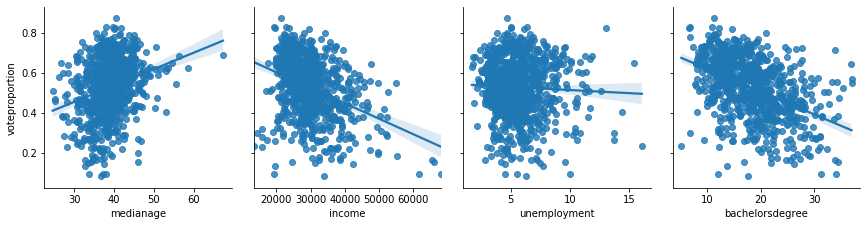

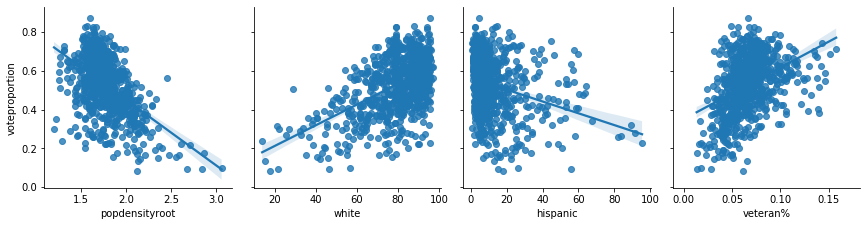

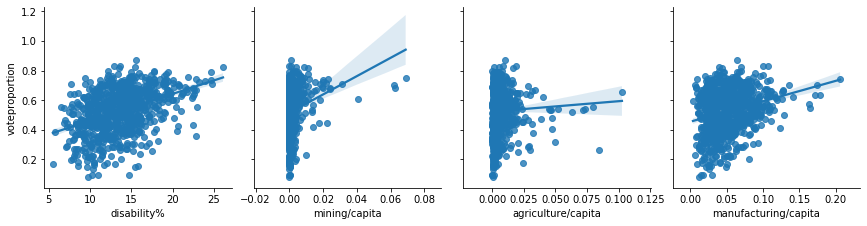

In [21]:
def pplot_features(df, features,name):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, y_vars=['voteproportion'], x_vars=row, kind='reg', height=3)
        pp.savefig(name)
    return pp.savefig(name)

features = ['medianage','income', 'unemployment','bachelorsdegree',
            'popdensityroot','white','hispanic','veteran%',
            'disability%','mining/capita','agriculture/capita',
            'manufacturing/capita']
pplot_features(test, features,'no_root_charts')

Apply standard scaler to indpendent variables included in model

In [13]:
scaler = StandardScaler()
columns_noroot = ['income','medianage','unemployment','bachelorsdegree','white','hispanic',
           'popdensity','veteran%','disability%','manufacturing/capita',
           'agriculture/capita','mining/capita']
scaled_noroot = scaler.fit_transform(test[columns_noroot], test['voteproportion'])
scaled_test_noroot = pd.DataFrame(scaled_noroot, columns=columns_noroot)
scaled_test_noroot['voteproportion'] = test['voteproportion']
scaled_test_noroot.head(5)

,income,medianage,unemployment,bachelorsdegree,white,hispanic,popdensity,veteran%,disability%,manufacturing/capita,agriculture/capita,mining/capita,voteproportion
0,0.028742,0.759583,-1.047666,-0.130716,5.292889e-01,-0.556172,-0.197220,0.946599,0.369256,-0.272117,-0.220219,-0.232787,0.765457
1,-0.840317,0.063052,1.735614,-1.498423,-3.731469e-01,-0.615345,-0.180415,0.495759,2.298965,0.706203,0.101380,-0.222136,0.686633
2,-1.204506,0.337443,-0.510541,-1.143832,1.179882e+00,-0.563568,-0.202715,0.034547,0.573922,0.442505,0.374624,-0.212570,0.871043
3,-1.489818,0.210801,-0.364053,-1.920554,6.062408e-01,0.176097,-0.208799,-0.790028,-0.215505,1.955834,1.351870,-0.355762,0.828816
4,-0.499974,-0.105804,-0.412882,-0.400880,2.982415e-15,-0.807658,-0.196911,0.609552,1.041730,-0.033265,-0.302748,-0.317414,0.741653


Calculate independent variable correlation coefficients

In [25]:
scaled_test_noroot.corr().to_csv("corr_matrix.csv")
scaled_test_noroot.corr()

,income,medianage,unemployment,bachelorsdegree,white,hispanic,popdensity,veteran%,disability%,manufacturing/capita,agriculture/capita,mining/capita,voteproportion
income,1.000000,0.180782,-0.463649,0.806042,0.019062,-0.095889,0.255807,-0.196623,-0.583218,-0.105402,-0.216568,-0.102119,-0.367597
medianage,0.180782,1.000000,-0.024106,-0.134451,0.329929,-0.307551,-0.073034,0.384244,0.359633,0.060942,-0.085170,-0.134136,0.260324
unemployment,-0.463649,-0.024106,1.000000,-0.495721,-0.349333,0.194453,0.022481,0.122002,0.472692,-0.211850,0.153197,0.098207,-0.042467
bachelorsdegree,0.806042,-0.134451,-0.495721,1.000000,-0.040121,-0.091359,0.172117,-0.289484,-0.694389,-0.157977,-0.259495,-0.127186,-0.451708
white,0.019062,0.329929,-0.349333,-0.040121,1.000000,-0.217198,-0.271351,0.188639,0.132637,0.278833,0.066931,0.078088,0.512790
hispanic,-0.095889,-0.307551,0.194453,-0.091359,-0.217198,1.000000,0.132957,-0.273604,-0.177212,-0.301214,0.313562,0.226358,-0.276608
popdensity,0.255807,-0.073034,0.022481,0.172117,-0.271351,0.132957,1.000000,-0.249590,-0.135598,-0.122418,-0.106881,-0.051501,-0.316166
veteran%,-0.196623,0.384244,0.122002,-0.289484,0.188639,-0.273604,-0.249590,1.000000,0.482283,-0.165964,-0.024400,-0.031134,0.397499
disability%,-0.583218,0.359633,0.472692,-0.694389,0.132637,-0.177212,-0.135598,0.482283,1.000000,0.005739,0.048475,0.051211,0.418057
manufacturing/capita,-0.105402,0.060942,-0.211850,-0.157977,0.278833,-0.301214,-0.122418,-0.165964,0.005739,1.000000,0.000802,-0.158134,0.259472


Train test split data

In [18]:
def tt_split(df):
    ignore = ['voteproportion']
    Y = scaled_test_noroot['voteproportion']
    df = scaled_test_noroot.drop(columns=ignore, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(df, Y, random_state=22,test_size=0.2)
    return x_train, x_test, y_train, y_test

x_train_nr, x_test_nr, y_train_nr, y_test_nr = tt_split(scaled_test_noroot)


Fit variables to linear regression model

In [19]:
model_all_nr = sm.OLS(y_train_nr, sm.add_constant(x_train_nr[[key for key in x_train_nr]])).fit()
model_all_nr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         voteproportion   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     68.63
Date:                Fri, 08 May 2020   Prob (F-statistic):          4.91e-105
Time:                        09:18:29   Log-Likelihood:                 566.78
No. Observations:                 628   AIC:                            -1108.
Df Residuals:                     615   BIC:                            -1050.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5274      0.004    132.979      0.000       0.520       0.535
income                  -0.0216      0.008     -2.576      0.010      -0.038      -0.005
medianage                0.0052      0.006      0.876      0.382      -0.006       0.017
unemployment            -0.0221      0.006     -3.982      0.000      -0.033      -0.011
bachelorsdegree         -0.0422      0.009     -4.807      0.000      -0.059      -0.025
white                    0.0442      0.005      8.233      0.000       0.034       0.055
hispanic                -0.0269      0.005     -5.202      0.000      -0.037      -0.017
popdensity              -0.0143      0.006     -2.323      0.020      -0.026      -0.002
veteran%                 0.0279      0.005      5.290      0.000       0.018       0.038
disability%              0.0026      0.007      0.358      0.721      -0.012       0.017
manufacturing/capita     0.0131      0.005      2.598      0.010       0.003       0.023
agriculture/capita      -0.0048      0.005     -0.939      0.348      -0.015       0.005
mining/capita            0.0335      0.004      7.788      0.000       0.025       0.042
==============================================================================
Omnibus:                        1.053   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                1.062
Skew:                           0.099   Prob(JB):                        0.588
Kurtosis:                       2.967   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fit variables to lasso model

In [17]:
lasso = Lasso(alpha=0.01, normalize=False)
lasso.fit(x_train, y_train)

y_train_pred = lasso.predict(x_train)
y_pred = lasso.predict(x_test)

Calculate training and testing error

In [18]:
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse))
print('Testing Error: '+ str(test_rmse)) 

Training Error: 0.08131491250169752
Testing Error: 0.0919128932446786


Save lasso coefficients to a dataframe

In [19]:
lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = x_train.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T

lasso_coef

,bachelorsdegree,hispanic,popdensityroot,incomeroot,unemployment,medianageroot,disability%root,agriculture/capita,manufacturing/capitaroot,mining/capita,veteran%root,white
0,-0.035452,-0.016884,-0.009272,-0.005742,-0.001397,0.0,0.0,-0.0,0.011887,0.020693,0.02659,0.045451


Scrap work with exploratory projects

In [20]:
train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
test_mae = metrics.mean_absolute_error(y_test, y_pred)
print('Training Error: '+ str(train_mae))
print('Testing Error: '+ str(test_mae)) 

Training Error: 0.08131491250169752
Testing Error: 0.07573080853698212


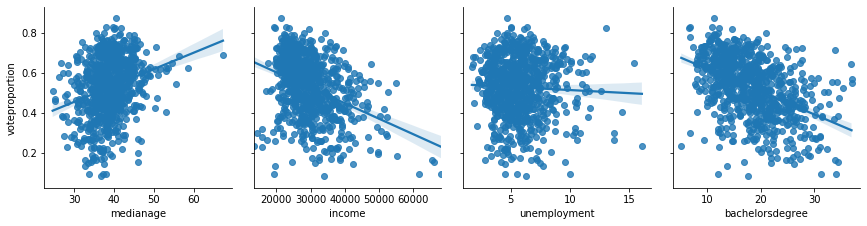

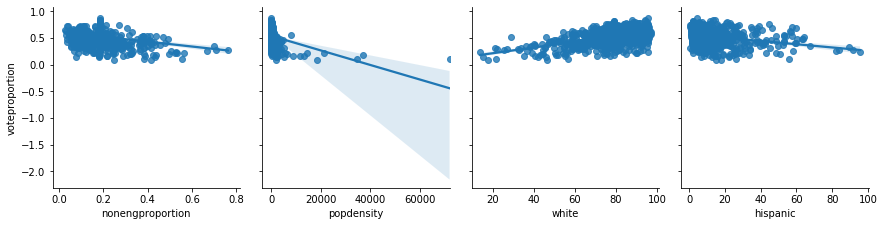

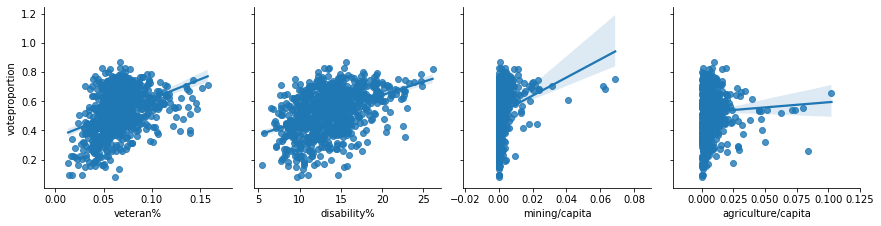

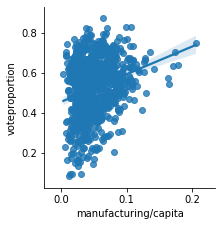

In [21]:
features = ['medianage','income', 'unemployment','bachelorsdegree',
            'nonengproportion','popdensity','white','hispanic','veteran%',
            'disability%','mining/capita','agriculture/capita',
            'manufacturing/capita']
pplot_features(test, features)

In [15]:
scaler = StandardScaler()
columns_noroot = ['income','medianage','unemployment','bachelorsdegree','white','hispanic',
           'popdensity','veteran%','disability%','manufacturing/capita',
           'agriculture/capita','mining/capita']
scaled_noroot = scaler.fit_transform(test[columns_noroot], test['voteproportion'])
scaled_test_noroot = pd.DataFrame(scaled_noroot, columns=columns_noroot)
scaled_test_noroot['voteproportion'] = test['voteproportion']
scaled_test_noroot.head(5)

,income,medianage,unemployment,bachelorsdegree,white,hispanic,popdensity,veteran%,disability%,manufacturing/capita,agriculture/capita,mining/capita,voteproportion
0,0.028742,0.759583,-1.047666,-0.130716,5.292889e-01,-0.556172,-0.197220,0.946599,0.369256,-0.272117,-0.220219,-0.232787,0.765457
1,-0.840317,0.063052,1.735614,-1.498423,-3.731469e-01,-0.615345,-0.180415,0.495759,2.298965,0.706203,0.101380,-0.222136,0.686633
2,-1.204506,0.337443,-0.510541,-1.143832,1.179882e+00,-0.563568,-0.202715,0.034547,0.573922,0.442505,0.374624,-0.212570,0.871043
3,-1.489818,0.210801,-0.364053,-1.920554,6.062408e-01,0.176097,-0.208799,-0.790028,-0.215505,1.955834,1.351870,-0.355762,0.828816
4,-0.499974,-0.105804,-0.412882,-0.400880,2.982415e-15,-0.807658,-0.196911,0.609552,1.041730,-0.033265,-0.302748,-0.317414,0.741653


In [27]:
x_train_nr, x_test_nr, y_train_nr, y_test_nr = tt_split(scaled_test_noroot)

In [28]:
model_all_nr = sm.OLS(y_train_nr, sm.add_constant(x_train_nr[[key for key in x_train_nr]])).fit()
model_all_nr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         voteproportion   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     70.41
Date:                Fri, 08 May 2020   Prob (F-statistic):          5.52e-107
Time:                        09:13:17   Log-Likelihood:                 571.41
No. Observations:                 628   AIC:                            -1117.
Df Residuals:                     615   BIC:                            -1059.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.5277      0.004    134.100      0.000       0.520       0.535
incomeroot                  -0.0306      0.009     -3.326      0.001      -0.049      -0.013
medianageroot                0.0114      0.006      1.918      0.056      -0.000       0.023
unemployment                -0.0204      0.006     -3.706      0.000      -0.031      -0.010
bachelorsdegree             -0.0369      0.009     -4.127      0.000      -0.054      -0.019
white                        0.0419      0.006      7.554      0.000       0.031       0.053
hispanic                    -0.0219      0.005     -3.988      0.000      -0.033      -0.011
popdensityroot              -0.0118      0.006     -1.864      0.063      -0.024       0.001
veteran%root                 0.0324      0.006      5.728      0.000       0.021       0.044
disability%root             -0.0087      0.007     -1.171      0.242      -0.023       0.006
manufacturing/capitaroot     0.0170      0.005      3.374      0.001       0.007       0.027
agriculture/capita          -0.0097      0.006     -1.749      0.081      -0.021       0.001
mining/capita                0.0330      0.004      7.500      0.000       0.024       0.042
==============================================================================
Omnibus:                        0.491   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.782   Jarque-Bera (JB):                0.516
Skew:                           0.068   Prob(JB):                        0.773
Kurtosis:                       2.962   Cond. No.                         5.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
lasso_nr = Lasso(alpha=0.01, normalize=False)
lasso_nr.fit(x_train_nr, y_train_nr)

y_train_pred_nr = lasso_nr.predict(x_train_nr)
y_pred_nr = lasso_nr.predict(x_test_nr)